In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from model_util import *

### Import data

In [102]:
df_Ch001 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl"))
df_Ch009 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl"))
df_Ch020 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl"))
df_Ch022 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl"))

### scaling data

In [103]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_input=[df_Ch001, df_Ch020, df_Ch009]
df_input_scaled=[]

LOG_SCALE= True
scaler=MinMaxScaler()

for df in df_input:
    df_input_scaled.append(data_scale(df, scaler, LOG_SCALE))

df_output_scaled, output_scaler = data_scale(df_Ch022, scaler, LOG_SCALE, output= True)

### formatting data

In [104]:
data=np.dstack(df_input_scaled)
data= np.expand_dims(data, axis=1)
target=df_output_scaled.copy().values

print(data.shape, target.shape)

(4722, 1, 34, 3) (4722, 34)


### split and transform data to tensor


In [105]:
#split data into test and train

size=len(df_Ch022.index)
split=int(size*0.15)

X_test=data[:split]
y_test=target[:split]

data_train=data[split:]
target_train=target[split:]

In [106]:
import torch
from sklearn.model_selection import train_test_split

In [107]:
#split data into train and val, transform all data to pytorch tensor

X_train, X_val, y_train, y_val = train_test_split(data_train, target_train, test_size=0.15, random_state=10)

X_train = torch.tensor(X_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)

X_test=torch.tensor(X_test, dtype=torch.float)

train_size=y_train.shape[0]
val_size=y_val.shape[0]

In [108]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [109]:
trainset = TensorDataset(X_train, y_train)
train_loader = DataLoader(trainset, batch_size=256)
validationset= TensorDataset(X_val, y_val)
val_loader = DataLoader(validationset, batch_size=256)

### CNN model

In [110]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 50, 3, padding=1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,1))
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(50, 150 ,3),
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,1))
        )
        
        self.fc1 = nn.Linear(150*5,400)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 34)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,150*5)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

### Creating Model, Optimizer and Loss

In [111]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [112]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [113]:
# defining the number of epochs
epochs = 40
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [114]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [115]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=3, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [116]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### model save

In [117]:
if LOG_SCALE:
    checkpointer = ModelCheckpoint(Path('./saved_models'), 'CNN_log', n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)
else:
        checkpointer = ModelCheckpoint(Path('./saved_models'), 'CNN', n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {"v1": model})

### Run Engine

In [118]:
# trainer.run(train_loader, max_epochs=epochs)

### Plotting the loss and accuracy

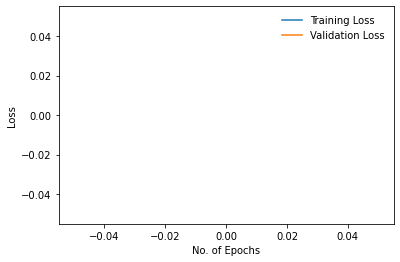

In [119]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk

In [120]:
model.load_state_dict(torch.load(Path("C:/Users/Victor/Desktop/PIR/model/saved_models/CNN_log_v1_294.pt")))
print("Model Loaded")

Model Loaded


In [121]:
from sklearn.metrics import mean_squared_error

In [122]:
model.to("cpu")

y_pred_test=model(X_test).detach().numpy()
print(type(y_test))

<class 'numpy.ndarray'>


In [133]:
data2=torch.tensor(data, dtype=torch.float)
y_pred= model(data2).detach().numpy()
y_pred= output_scaler.inverse_transform(y_pred)
if LOG_SCALE:
    y_pred=10 ** y_pred

In [123]:
y_test=output_scaler.inverse_transform(y_test)
y_pred_test= output_scaler.inverse_transform(y_pred_test)
if LOG_SCALE:
    y_pred_test=10 ** y_pred_test
    y_test=10 ** y_test

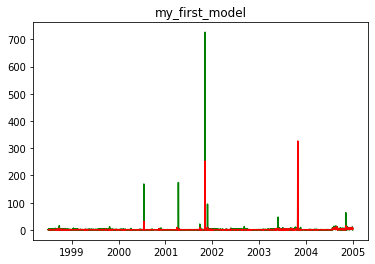

In [140]:
    p=5
    plt.figure()
    # plt.plot(df_Ch022.index[:split], y_test[:,p], color= "blue")
    plt.plot(df_Ch022.index[:], df_Ch022.iloc[:,p], color="green" )
    plt.plot(df_Ch022.index[:], y_pred[:,p], color="red")
    plt.title("my_first_model")

    plt.show()

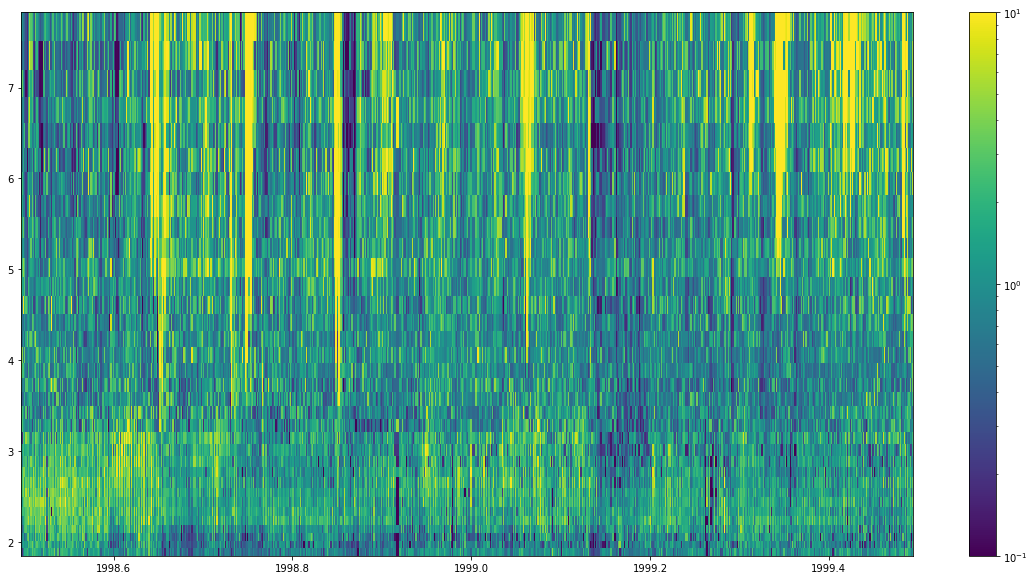

In [125]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 10))
plt.pcolormesh(
    df_Ch022.index[:split],
    df_Ch022.columns,
    y_test.T / y_pred_test.T,
    norm=LogNorm(1e-1, 10),
    shading="auto",
)
plt.colorbar()
plt.show()

In [126]:
MSE=[]
for p in range(34):
    MSE.append(mean_squared_error(y_test[:,p], y_pred_test[:,p]))


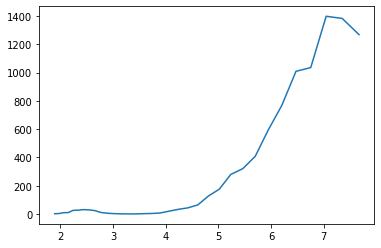

In [127]:
plt.figure()
plt.plot(df_Ch022.columns[:], MSE[:])
# plt.savefig(Path("./MSE_log_CNN_1"), facecolor="w")
plt.show()